### what to do:

 - implement a 2-class classification neural network with single one hidden layer
 - use unit with a non-linear activation function
 - implement the forward propagation and backward propagation for neural network with one hidden layer
 - compute the cost function

### 1 - package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from planar_utils import load_planar_dataset
import sklearn.linear_model
from testCases_v2 import *

%matplotlib inline
np.random.seed(1)

### 2 - dataset

get a better sense of what our data is look like.

In [2]:
X, Y = load_planar_dataset()
print('the shape of X is:', X.shape)
print('the shape of Y is:', Y.shape)
print('training examples:', X.shape[1])
print('feature size:', X.shape[0])
m = X.shape[1]

the shape of X is: (2, 400)
the shape of Y is: (1, 400)
training examples: 400
feature size: 2


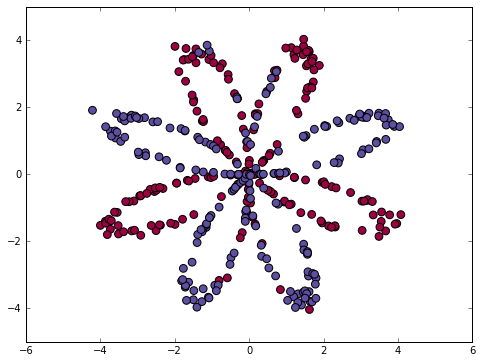

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X[0,:], X[1,:], s = 60, c = Y, cmap=plt.cm.Spectral)

### 3 - simple logistic regression

In [4]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T, Y.T)
logistic_regression_prediction = clf.predict(X.T)

print(logistic_regression_prediction.shape, Y.T.shape)
logistic_regression_prediction = logistic_regression_prediction.reshape((logistic_regression_prediction.shape[0], 1))

print('Accuracy of logistic regression: %f%%' % (np.mean(np.where(logistic_regression_prediction == Y.T, 1, 0)) * 100))

D:\soft\Ana\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(400,) (400, 1)
Accuracy of logistic regression: 47.000000%


In [5]:
def plot_decision_boundary(model, X, Y):
    x_min, x_max = np.min(X[0,:]) - 1, np.max(X[0,:]) + 1
    y_min, y_max = np.min(X[1,:]) - 1, np.max(X[1,:]) + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.scatter(X[0, :], X[1, :], s = 60, c = Y, cmap = plt.cm.Spectral_r)

D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


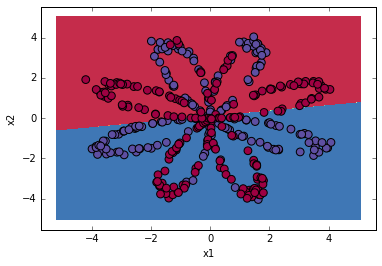

In [6]:
plot_decision_boundary(clf.predict, X, Y)

the dataset is not linearly separable, so logistic regression doesn't perform well, hopefully the neural network will do bitter. 

### 4 - neural network model

For one example $x^{(i)}$:

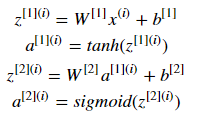

In [29]:
from IPython.display import Image, display
Image('images/01.png', width=200)

Given the predictions on all examples, you can also compute the cost $J$ as following:

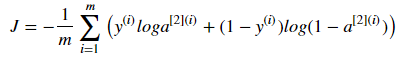

In [32]:
Image('images/02.png', width=400)

**Reminder:** the general mothodology to building a neural network is to:

    1. define the neural network structure(# of hidden layer, # of unit on each layer)
    2. initialize the model's parameters
    3. loop:
        - implement forward propagation
        - compute the cost
        - implement backpropagation to get the gradient
        - update parameters use gradient descent

#### 4-1 network structure
Use shapes of X and Y to find n_x and n_y

In [7]:
def layer_size(X, Y):
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    return (n_x, n_h, n_y)

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
n_x, n_h, n_y = layer_size(X_assess, Y_assess)
print('the size of input layer:', n_x)
print('the size of hidden layer:', n_h)
print('the size of output layer:', n_y)

the size of input layer: 5
the size of hidden layer: 4
the size of output layer: 2


#### 4 - 2 initialize the model's parameters

In [9]:
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    parameters = {'W1':W1,
                 'b1':b1,
                 'W2':W2,
                 'b2':b2}
    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, n_h, n_y)
print('W1 = ', parameters['W1'])
print('b1 = ', parameters['b1'])
print('W2 = ', parameters['W2'])
print('b2 = ', parameters['b2'])

W1 =  [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 =  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
W2 =  [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 =  [[ 0.]]


#### 4.3 - loop

##### 4.3.1 - helper function

In [11]:
def sigmoid(z):
    return 1./(1. + np.exp(-z))

##### 4.3.2 - forward propagation

In [12]:
def forward_propagation(X, parameters):
    m = X.shape[1]
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(Z1.shape == (n_h, m))
    assert(A1.shape == (n_h, m))
    assert(Z2.shape == (n_y, m))
    assert(A2.shape == (n_y, m))
    
    cache = {'Z1':Z1,
             'A1':A1,
             'Z2':Z2,
             'A2':A2}
    return A2, cache

In [13]:
X_assess, parameters_assess = forward_propagation_test_case()
A2, cache = forward_propagation(X_assess, parameters_assess)
print('Z1', cache['Z1'])
print('A1', cache['A1'])
print('Z2', cache['Z2'])
print('A2', cache['A2'])
print('-' * 50)
print('mean Z1', np.mean(cache['Z1']))
print('mean A1', np.mean(cache['A1']))
print('mean Z2', np.mean(cache['Z2']))
print('mean A2', np.mean(cache['A2']))

Z1 [[ 1.7386459   1.74687437  1.74830797]
 [-0.81350569 -0.73394355 -0.78767559]
 [ 0.29893918  0.32272601  0.34788465]
 [-0.2278403  -0.2632236  -0.22336567]]
A1 [[ 0.9400694   0.94101876  0.94118266]
 [-0.67151964 -0.62547205 -0.65709025]
 [ 0.29034152  0.31196971  0.33449821]
 [-0.22397799 -0.25730819 -0.2197236 ]]
Z2 [[-1.30737426 -1.30844761 -1.30717618]]
A2 [[ 0.21292656  0.21274673  0.21295976]]
--------------------------------------------------
mean Z1 0.262818640198
mean A1 0.091999045227
mean Z2 -1.30766601287
mean A2 0.212877681719


##### 4.3.3 - cost function

In [14]:
def compute_cost(A2, Y):
    m = Y.shape[1]
    cost = np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2)) / (-m)
    cost = np.squeeze(cost)
    assert(isinstance(cost, float))
    return cost

In [15]:
A2_assess, Y_assess, parameters_assess = compute_cost_test_case()
cost = compute_cost(A2_assess, Y_assess)
print('cost', cost)

cost 0.693058761039


##### 4.3.4 - backward propagation

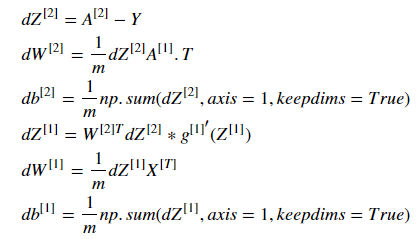

In [35]:
Image('images/03.png', width=400)

In [16]:
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    
    W2 = parameters['W2']
    
    Z1 = cache['Z1']
    Z2 = cache['Z2']
    A2 = cache['A2']
    A1 = cache['A1']
    
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(np.tanh(Z1), 2))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    assert(dZ2.shape == Z2.shape)
    assert(W2.shape == dW2.shape)
    
    grads = {'dW1':dW1,
             'db1':db1,
             'dW2':dW2,
             'db2':db2}
    return grads

In [17]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()
grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print('dW1 = ', grads['dW1'])
print('db1 = ', grads['db1'])
print('dW2 = ', grads['dW2'])
print('db2 = ', grads['db2'])

dW1 =  [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]]
db1 =  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]]
dW2 =  [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]]
db2 =  [[-0.16655712]]


##### 4.3.5 - update parameters
general gradient descent rule: $\theta = \theta - \alpha \frac{\partial J}{\partial \theta} $, where $\alpha$ is the learning rate, and $\theta$ represents a paramenter

In [18]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2
    }
    return parameters

In [19]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)
print('W1 = ', parameters['W1'])
print('b1 = ', parameters['b1'])
print('W2 = ', parameters['W2'])
print('b2 = ', parameters['b2'])

W1 =  [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 =  [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]
W2 =  [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 =  [[ 0.00010457]]


#### 4.4 - integrate part 4.1, 4.2 and 4.3 in nn_model()

In [20]:
def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate = 0.001, print_cost = False):
    np.random.seed(3)
    n_x = layer_size(X, Y)[0]
    n_y = layer_size(X, Y)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    for i in range(num_iterations):
        A2, cache = forward_propagation(X, parameters)
        cost = compute_cost(A2, Y)
        grads = backward_propagation(parameters, cache, X, Y)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 1000 == 0 and print_cost == True:
            print('Cost after interation %d: %f' % (i, cost))
            
    return parameters

In [21]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, 10000, 1.2, True)
print('W1 = ', parameters['W1'])
print('b1 = ', parameters['b1'])
print('W2 = ', parameters['W2'])
print('b2 = ', parameters['b2'])

Cost after interation 0: 0.692739
Cost after interation 1000: 0.000218
Cost after interation 2000: 0.000107
Cost after interation 3000: 0.000071
Cost after interation 4000: 0.000053
Cost after interation 5000: 0.000042
Cost after interation 6000: 0.000035
Cost after interation 7000: 0.000030
Cost after interation 8000: 0.000026
Cost after interation 9000: 0.000023
W1 =  [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]
b1 =  [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]]
W2 =  [[-2.45566237 -3.27042274  2.00784958  3.36773273]]
b2 =  [[ 0.20459656]]


#### 4.5 - prediction

In [22]:
def prediction(parameters, X):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    Y_predictions = np.where(A2 > 0.5, 1, 0)
    return Y_predictions

In [23]:
parameters, X_assess = predict_test_case()
Y_predictions = prediction(parameters, X_assess)
print('predictions mean = ', np.mean(Y_predictions))

predictions mean =  0.666666666667


### 5 - flower data classifier by neural network with one hidden layer

Cost after interation 0: 0.693048
Cost after interation 1000: 0.288083
Cost after interation 2000: 0.254385
Cost after interation 3000: 0.233864
Cost after interation 4000: 0.226792
Cost after interation 5000: 0.222644
Cost after interation 6000: 0.219731
Cost after interation 7000: 0.217504
Cost after interation 8000: 0.219528
Cost after interation 9000: 0.218627


D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


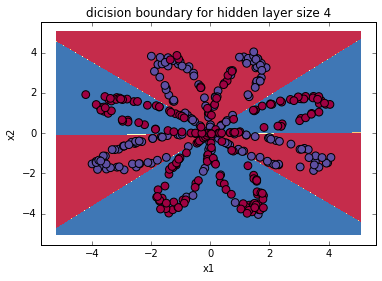

In [24]:
parameters = nn_model(X, Y, 4, num_iterations=10000, learning_rate=1.2, print_cost=True)

plot_decision_boundary(lambda x:prediction(parameters, x.T), X, Y)
plt.title('dicision boundary for hidden layer size ' + str(4))

In [25]:
Y_predictions = prediction(parameters, X)
print('Accuracy: %f%%' % (np.mean(np.where(Y == Y_predictions, 1, 0)) * 100))

Accuracy: 90.500000%


Accuracy is really high compared to the logistic regression, so neural network are able to learn even highly non-linear decision boundary, unlike logistic regression.

### 6 - tuning hidden layer size

D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
D:\soft\Ana\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


Accuracy for 1 hidden units: 67.500000%
Accuracy for 2 hidden units: 67.250000%
Accuracy for 3 hidden units: 90.750000%
Accuracy for 4 hidden units: 90.500000%
Accuracy for 5 hidden units: 91.250000%
Accuracy for 10 hidden units: 90.250000%
Accuracy for 20 hidden units: 90.500000%
Accuracy for 50 hidden units: 90.250000%


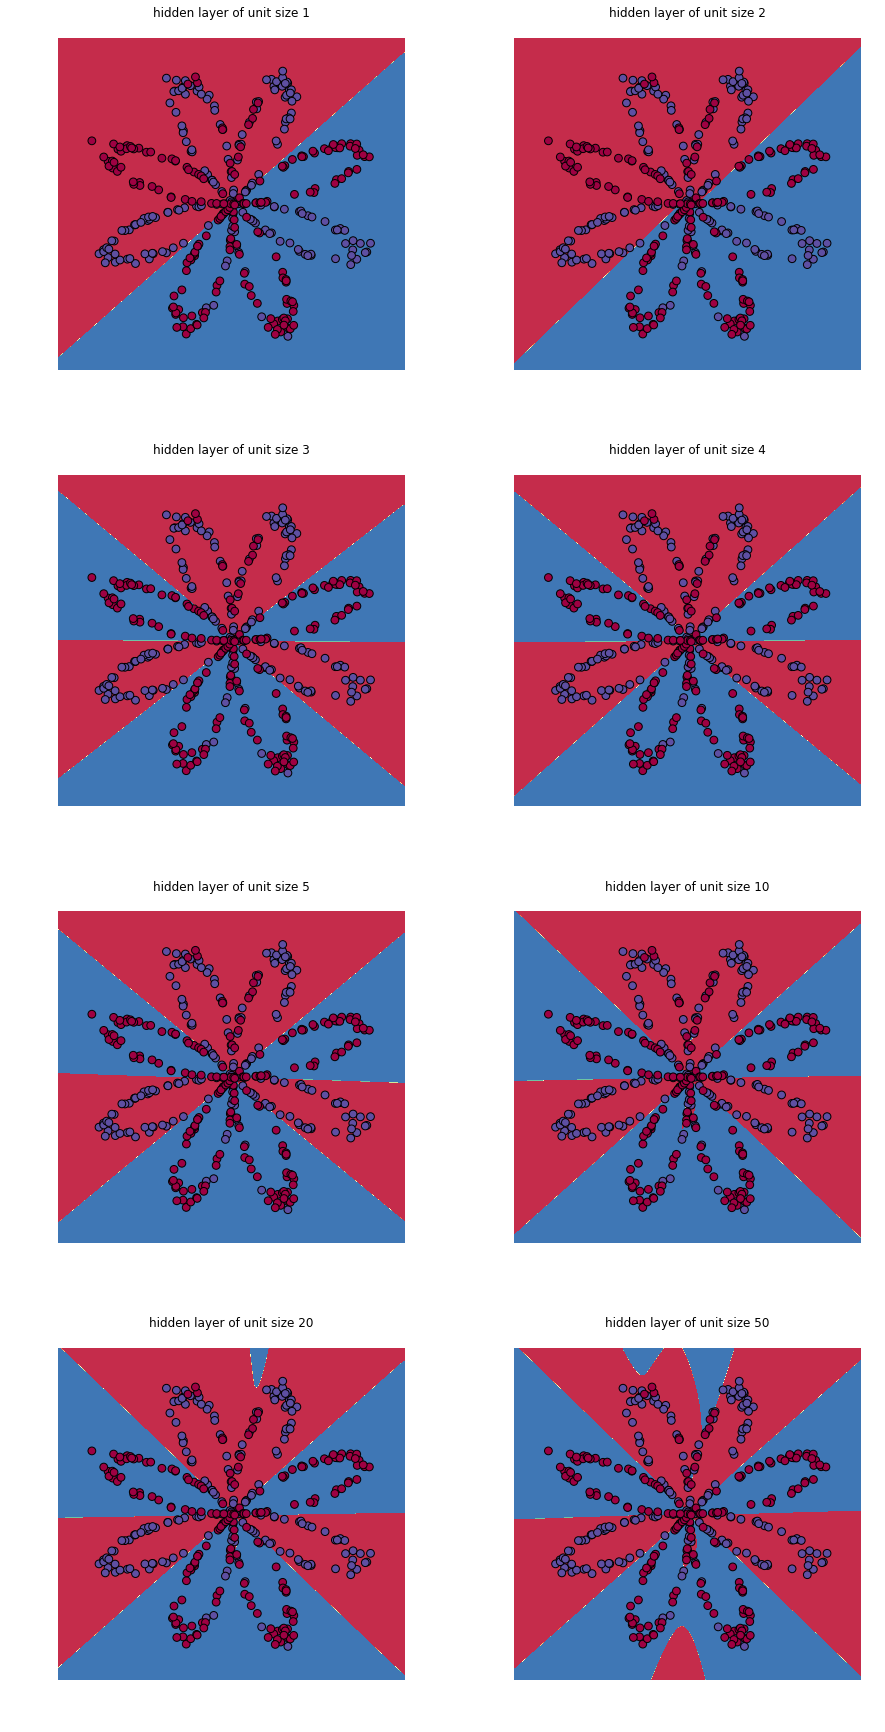

In [26]:
hidden_layer_size = [1,2,3,4,5,10,20,50]
plt.figure(figsize=(15, 30))
for i, n_h in enumerate(hidden_layer_size):
    plt.subplot(4, 2, i + 1)
    parameters = nn_model(X, Y, n_h, num_iterations=5000, learning_rate=1.2, print_cost=False)
    plot_decision_boundary(lambda x:prediction(parameters, x.T), X, Y)
    plt.axis('off')
    plt.title('hidden layer of unit size ' + str(n_h))
    Y_predictions = prediction(parameters, X)
    print('Accuracy for %d hidden units: %f%%' % (n_h, np.mean(np.where(Y == Y_predictions, 1, 0)) * 100))